# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=b0d060b566edb26587ec794efc78c51145d410032f578f7e515be1a1f033214b
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 9.28s ===============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [4]:
batch_size = 256  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 30  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0001 # regularization. Increase this to combat overfitting

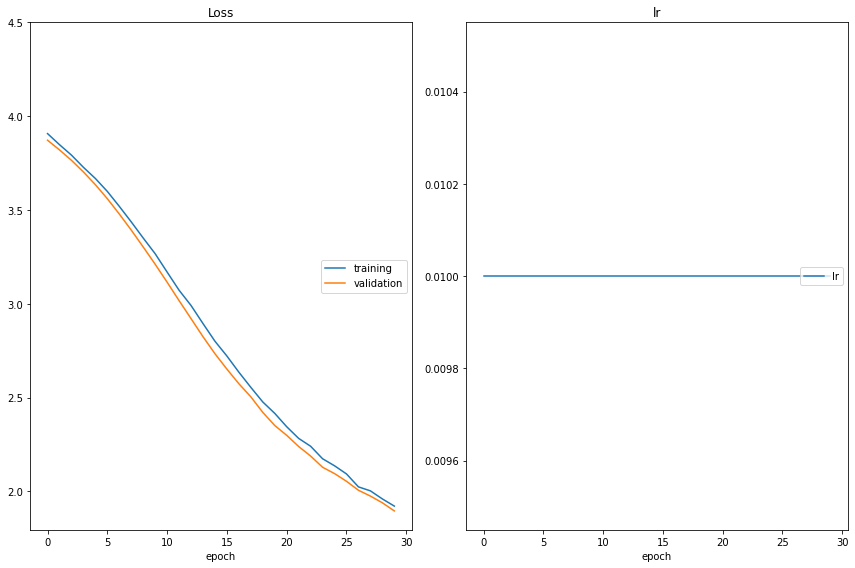

In [5]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# Using ResNet 50

model_transfer = get_model_transfer_learning(model_name="resnet50", n_classes=num_classes)

# Get data loaders for training and validation datasets.
data_loaders = get_data_loaders(batch_size=batch_size)

# Get the optimizer for the model using the specified learning rate, optimizer type, and weight decay.
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)

# Get the loss function for optimization.
loss = get_loss()

# Train the model over a specified number of epochs, saving the best model to a specified path.
optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ Initially, I experimented with ResNet-18, but it didn’t lead to significant enhancements. I then explored various ResNet models with additional layers and ultimately chose ResNet-50. The choice was driven by ResNet-50’s superior ability to discern complex patterns and features in large datasets. Furthermore, ResNet-50 outperforms most models, including ResNet-18, in transfer learning scenarios due to its effective fine-tuning of pre-trained models.


Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [6]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

# Get a pre-trained model using get_model_transfer_learning. 
model_transfer = get_model_transfer_learning("resnet50", n_classes=num_classes)

# Load the saved weights from the specified path.
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer1.pt'))

# Test the model using the test data loader and the specified loss function.
one_epoch_test(data_loaders['test'], model_transfer, loss)


Testing: 100%|████████████████████████████████████| 5/5 [00:22<00:00,  4.45s/it]

Test Loss: 1.463121


Test Accuracy: 61% (764/1250)


1.463120698928833

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [11]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# Get the class names from the training data loader.
class_names = data_loaders["train"].dataset.classes

# Move the model to CPU as we don't need GPU for inference.
model_transfer = model_transfer.cpu()

# Load the best weights found during training into the model.
# Use map_location='cpu' to load the weights on the CPU.
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Compute mean and standard deviation for normalization.
mean, std = compute_mean_and_std()

# Wrap our model using the predictor class.
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export the predictor using torch.jit.script for optimization and portability.
scripted_predictor = torch.jit.script(predictor)

# Save the scripted predictor to a file for future use.
scripted_predictor.save("checkpoints/transfer_exported.pt")


Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [29:51<00:00,  1.43s/it]


Accuracy: 0.656


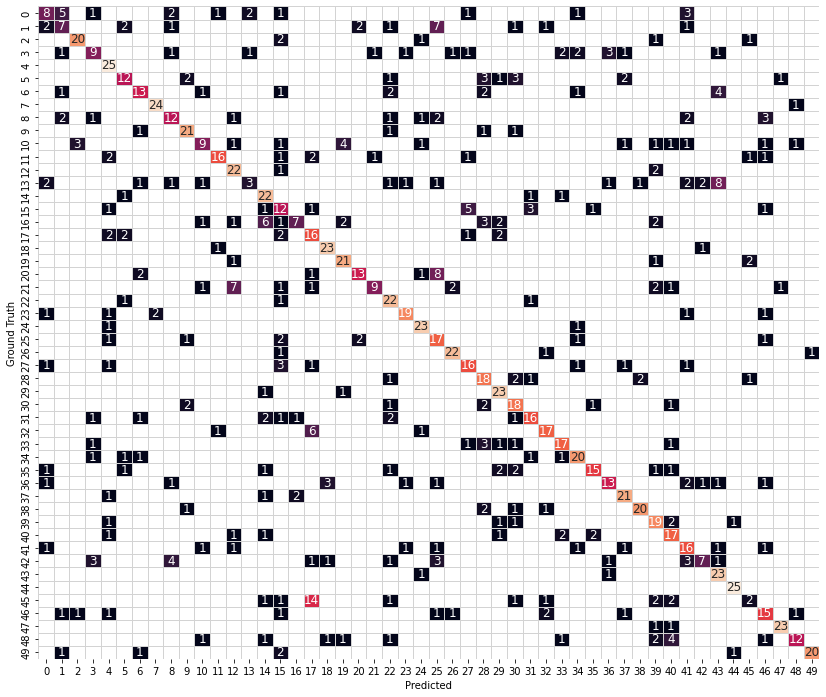

In [8]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

# Load the previously saved scripted model using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

# Test the reloaded model using the test data loader and get the predicted and true labels
pred, truth = predictor_test(data_loaders['test'], model_reloaded)

# Plot a confusion matrix of the predicted and true labels
plot_confusion_matrix(pred, truth)
